### Loading data

In [17]:
# Loading necessary modules
import pandas as pd
#import warnings
#warnings.filterwarnings('ignore')
#import matplotlib.pyplot as plt
#import seaborn as sns
from wordcloud import STOPWORDS, WordCloud
#from gensim.models import CoherenceModel
from gensim import corpora
#from pprint import pprint
#import string
#import re
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /home/doit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Read csv in to data
tweet_data = pd.read_csv('processed_tweet_data.csv')

In [3]:
# print top 5 rows
tweet_data.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Jun 18 17:55:49 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...","🚨Africa is ""in the midst of a full-blown third...",0.166667,0.188889,en,548,612,ketuesriche,551,351,NaN,[],"[{'screen_name': 'TelGlobalHealth', 'name': 'T...",Mass
1,Fri Jun 18 17:55:59 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Dr Moeti is head of WHO in Africa, and one of ...",0.133333,0.455556,en,195,92,Grid1949,66,92,NaN,[],"[{'screen_name': 'globalhlthtwit', 'name': 'An...","Edinburgh, Scotland"
2,Fri Jun 18 17:56:07 +0000 2021,"<a href=""http://twitter.com/download/iphone"" r...",Thank you @research2note for creating this ama...,0.316667,0.483333,en,2,1,LeeTomlinson8,1195,1176,NaN,"[{'text': 'red4research', 'indices': [103, 116]}]","[{'screen_name': 'NHSRDForum', 'name': 'NHS R&...",NaN
3,Fri Jun 18 17:56:10 +0000 2021,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111,0.197222,en,1580,899,RIPNY08,2666,2704,NaN,[],"[{'screen_name': 'HighWireTalk', 'name': 'The ...",NaN
4,Fri Jun 18 17:56:20 +0000 2021,"<a href=""http://twitter.com/download/android"" ...",I think it’s important that we don’t sell COVA...,0.280000,0.620000,en,72,20,pash22,28250,30819,NaN,[],"[{'screen_name': 'PeterHotez', 'name': 'Prof P...",United Kingdom


### Data cleaning

* Since the goal of this analysis is to perform topic modeling, let's focus only on the text data and polarity.

In [4]:
# select only 'original_text' and 'polarity' columns
tweet_data = tweet_data[['original_text', 'polarity']]
tweet_data.head()

,original_text,polarity
0,"🚨Africa is ""in the midst of a full-blown third...",0.166667
1,"Dr Moeti is head of WHO in Africa, and one of ...",0.133333
2,Thank you @research2note for creating this ama...,0.316667
3,"Former Pfizer VP and Virologist, Dr. Michael Y...",0.086111
4,I think it’s important that we don’t sell COVA...,0.280000


In [5]:
# text Preprocessing
tweet_data['original_text']=tweet_data['original_text'].astype(str)

# Convert to lowercase
tweet_data['original_text'] = tweet_data['original_text'].map(lambda x: x.lower())

# Remove punctuation
tweet_data['original_text']= \
tweet_data['original_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [6]:
tweet_data.head()

,original_text,polarity
0,🚨africa is in the midst of a fullblown third w...,0.166667
1,dr moeti is head of who in africa and one of t...,0.133333
2,thank you research2note for creating this amaz...,0.316667
3,former pfizer vp and virologist dr michael yea...,0.086111
4,i think it’s important that we don’t sell cova...,0.280000


### Exploratory analysis
* To verify whether the preprocessing, we’ll make a simple word cloud using the `wordcloud` package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

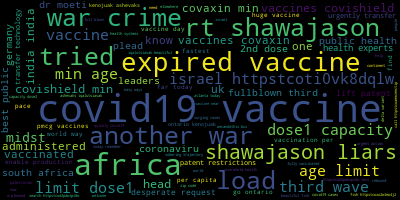

In [10]:
# Join the different processed titles together.
long_string = ','.join(list(tweet_data['original_text'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="black", max_words=800, contour_width=8, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Preparing data for LDA analysis
* Next, let’s work to transform the textual data in a format that will serve as an input for training LDA model. We start by tokenizing the text and removing stopwords. Next, we convert the tokenized object into a corpus and dictionary.

In [16]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


data = tweet_data.original_text.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0][:30])

['africa', 'midst', 'full', 'blown', 'third', 'wave', 'coronavirus', 'head', 'whoafro', 'warned', 'cases', 'risen', 'across', 'continent', 'deaths', 'also', 'risen', 'last', 'week', 'jriggers', 'reports', 'https', 'co', 'crdhqphfwm']


### LDA model training

### Analyzing LDA model results